Hao Sun_W4 code

# Part 1. Load Training data

In [1]:
from time import time
import pandas as pd
import numpy as np
from PIL import Image
import keras.layers.advanced_activations
import scipy
import random
import matplotlib.pyplot as plt  
from scipy.stats import norm  
import keras
from keras.models import Sequential
from keras.initializers import VarianceScaling,RandomNormal
from keras.layers import Input, Dense, Dropout, Conv2D, MaxPooling2D
from keras.layers import UpSampling2D, Reshape, Lambda, Flatten, Activation
from keras.models import Model  
from keras.optimizers import SGD, Adadelta, Adagrad,Adam
from keras import backend as K  
from keras import objectives  
from keras.utils.vis_utils import plot_model  
from keras.utils import np_utils, generic_utils
import sys 
import tensorflow as tf
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.layers.normalization import BatchNormalization
import matplotlib.pyplot as plt
import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import sklearn
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter
%matplotlib inline
from sklearn import manifold, datasets,cluster
from sklearn.utils import check_random_state

Using TensorFlow backend.


In [2]:
path = os.listdir('cstor/xsede/users/xs-haosun/SDSS_2000/')

Obj_ID = []
Image = []
Class = []
Redshift = []
for i in range(len(path)):
    path_now = path[i]
    a = np.load('cstor/xsede/users/xs-haosun/SDSS_2000/'+str(path_now))
    for j in range(a.shape[0]):
        Obj_ID.append(a[j]['objID'])
        Image.append(a[j]['image'])
        Class.append(a[j]['class'])
        Redshift.append(a[j]['z'])

Obj_ID = np.asarray(Obj_ID)
Image = np.asarray(Image)
Class = np.asarray(Class)
Redshift = np.asarray(Redshift)
Class[Class=='STAR'] = 0
Class[Class=='GALAXY'] = 1
Class[Class=='QSO'] = 2
Class = Class.astype(int)



In [3]:
Image_RGB = np.empty((len(Image),64,64,3))#(14142,64,64,3) RGB images
for i in range(len(Image)):
    #b[i] = np.stack((a[i][1][0],a[i][1][1],a[i][1][2],a[i][1][3],a[i][1][4]),axis=-1)
    Image_RGB[i] = np.stack((Image[i][3],Image[i][2],Image[i][1]),axis=-1)


for i in range(len(Image_RGB)):
    if True in np.isnan(Image_RGB[i]).reshape(64*64*3):
        print(i)
        Image_RGB[i][np.isnan(Image_RGB[i])==True]=np.mean(Image_RGB[i-1])

815


In [4]:
Image_RGB -= np.mean(Image_RGB)
Image_RGB /= np.max(Image_RGB)

In [5]:
label = np_utils.to_categorical(Class, 3)
data = Image_RGB
index = [i for i in range(len(data))]
#random.shuffle(index)
train_data = data[index]
train_label = label[index]
print('train_data.shape:',train_data.shape)
print('train_label.shape:',train_label.shape)
index = [i for i in range(len(train_data))]
#random.shuffle(index)
train_data = train_data[index]
train_label = train_label[index]
print('total ',train_data.shape[0], ' samples')

train_data.shape: (14142, 64, 64, 3)
train_label.shape: (14142, 3)
total  14142  samples


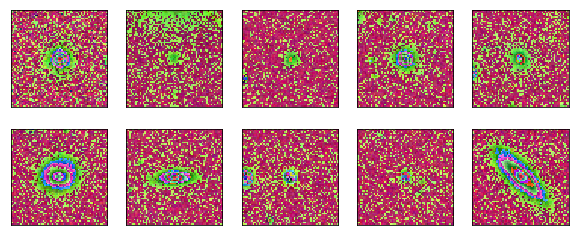

[1 1 1 1 1 1 1 0 2 1]


In [6]:
n=5
plt.figure(figsize=(10, 10*2/5))
for l in range(2):
    for i in range(n):
        ax = plt.subplot(2,n,l*n+i+1)
        plt.imshow((Image_RGB[10+l*5+i]))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
plt.show()
print(Class[10:20])

# Part 2. Build Model.

In [7]:
batch_size =100
latent_dim = 2
nb_epoch = 50  
epsilon_std = 1.0  
intermediate_dim_1 = 256
#intermediate_dim_2 = 300
original_dim = 64*64

input_img = Input(shape=(64,64,3))

conv_1 = Conv2D(40, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(input_img)
maxpool_1 = MaxPooling2D((2, 2),  padding='same')(conv_1)

conv_2 = Conv2D(40, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(maxpool_1)
maxpool_2 = MaxPooling2D((2, 2),  padding='same')(conv_2)

conv_3 = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(maxpool_2)
maxpool_3 = MaxPooling2D((2, 2),  padding='same')(conv_3)

conv_4 = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(maxpool_3)
maxpool_4 = MaxPooling2D((2, 2),  padding='same')(conv_4)

conv_5 = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(maxpool_4)
maxpool_5 = MaxPooling2D((2, 2),  padding='same')(conv_5)

#x = Conv2D(5, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(x)
#x = MaxPooling2D((2, 2),  padding='same')(x)

visual = Flatten()(maxpool_5)
h_1 = Dense(intermediate_dim_1, activation='tanh')(visual)
#h_2 = Dense(intermediate_dim_2, activation='tanh')(h_1)

z_mean = Dense(latent_dim)(h_1)
z_log_var = Dense(latent_dim)(h_1)

def sampling(args):   
    z_mean, z_log_var = args  
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0.,stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2)* epsilon

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

#h_3 = Dense(intermediate_dim_2,activation='tanh')(z)
h_4 = Dense(intermediate_dim_1,activation='tanh')(z)
h_5 = Dense(20*2*2,activation='relu')(h_4)
h_6 = Reshape((2,2,20))(h_5)


conv_6 = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(h_6)
upsample_6 = UpSampling2D((2, 2))(conv_6)

conv_7 = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(upsample_6)
upsample_7 = UpSampling2D((2, 2))(conv_7)

conv_8 = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(upsample_7)
upsample_8 = UpSampling2D((2, 2))(conv_8)

conv_9 = Conv2D(40, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(upsample_8)
upsample_9 = UpSampling2D((2, 2))(conv_9)

conv_10 = Conv2D(80,  (3, 3), activation='tanh',padding='same',kernel_initializer='normal')(upsample_9)
upsample_10 = UpSampling2D((2, 2))(conv_10)

decoded = Conv2D(3, (3, 3), activation='tanh', padding='same')(upsample_10)

EarlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')


def vae_loss(x, decoded):  
    xent_loss = K.sum(K.sum(objectives.binary_crossentropy(x ,decoded),axis=-1),axis=-1)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1) 
    return xent_loss + 1*kl_loss  


vae = Model(inputs=input_img, outputs=decoded) 
vae.compile(optimizer='rmsprop', loss=vae_loss) 

In [ ]:
vae.fit(train_data[:8000], train_data[:8000],  
        shuffle=True,  
        epochs=10,    
        batch_size=batch_size,  
        validation_data=(train_data[8000:9500],train_data[8000:9500]),callbacks=[EarlyStopping])  

In [8]:
vae.load_weights('Perfect classification.h5')

# Part 3. Hidden variables (for classification/ visualization)

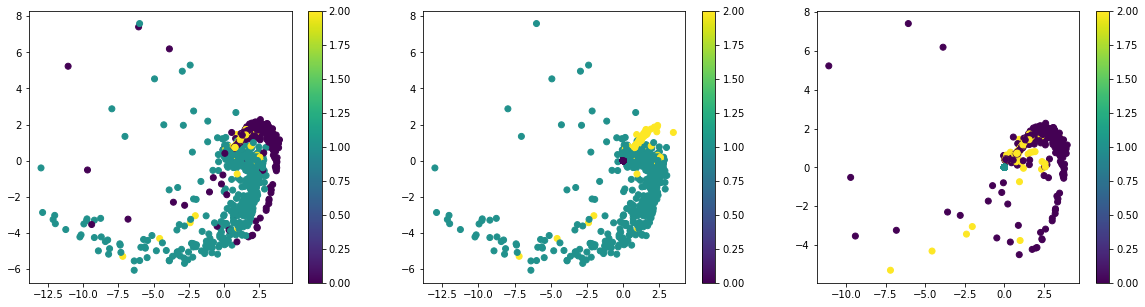

In [9]:
label_value = np.zeros(len(train_label))
for i in range(len(label_value)):
    label_value[i] =np.argmax(train_label[i])

vis = Model(input_img, z_mean)

# display a 2D plot of the digit classes in the latent space  
x_vis = vis.predict(train_data[8000:9500], batch_size=batch_size)

x_vis_1 = vis.predict(train_data[8000:9500], batch_size=batch_size)  
x_vis_1[label_value[8000:9500]<1]=0

x_vis_2 = vis.predict(train_data[8000:9500], batch_size=batch_size)  
x_vis_2[label_value[8000:9500]==1]=0

plt.figure(figsize=(20, 5))

ax = plt.subplot(1,3,1)
plt.scatter( x_vis[:, 0] ,x_vis[:, 1],c=label_value[8000:9500])
plt.colorbar()
ax = plt.subplot(1,3,2)
plt.scatter( x_vis_1[:, 0] ,x_vis_1[:, 1],c=label_value[8000:9500])
plt.colorbar()
ax = plt.subplot(1,3,3)
plt.scatter( x_vis_2[:, 0] ,x_vis_2[:, 1],c=label_value[8000:9500])
plt.colorbar()
plt.show()

# Part 4. Manifold learning approach to clustering

standard: 0.22 sec
modified: 0.38 sec
Isomap: 0.89 sec
MDS: 4.4 sec
SpectralEmbedding: 0.27 sec
t-SNE: 5.4 sec


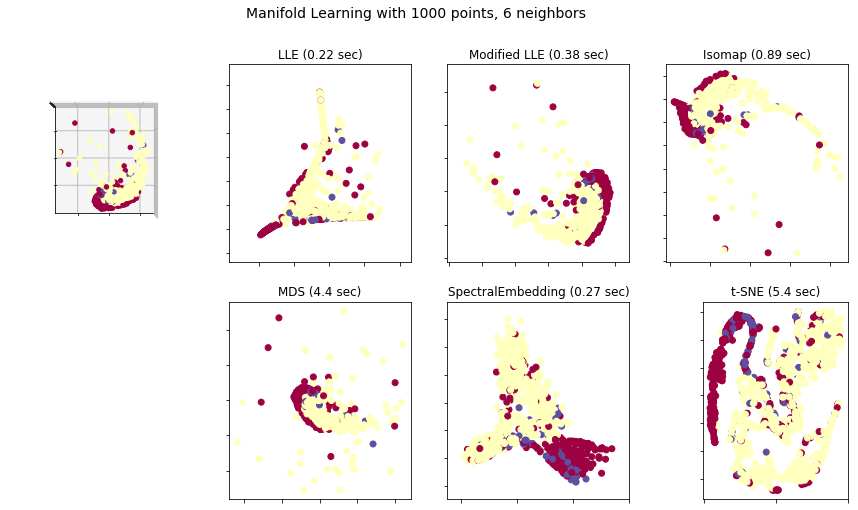

In [10]:
n_points = 1000
X = np.asarray(x_vis,dtype='float64')
color = label_value[8000:9500]
#X, color = datasets.samples_generator.make_s_curve(n_points, random_state=0)
#X = X.astype(np.float32)
n_neighbors = 6
n_components = 2

fig = plt.figure(figsize=(15, 8))
plt.suptitle("Manifold Learning with %i points, %i neighbors"
             % (1000, n_neighbors), fontsize=14)

try:
    # compatibility matplotlib < 1.0
    ax = fig.add_subplot(241, projection='3d')
    ax.scatter(X[:, 1], X[:, 0], c=color, cmap=plt.cm.Spectral)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.zaxis.set_major_formatter(NullFormatter())
    ax.view_init(90, 90)
except:
    ax = fig.add_subplot(241, projection='3d')
    plt.scatter(X[:, 1], X[:, 0], c=color, cmap=plt.cm.Spectral)

methods = ['standard', 'modified']
labels = ['LLE', 'Modified LLE']

for i, method in enumerate(methods):
    t0 = time()
    Y = manifold.LocallyLinearEmbedding(n_neighbors, n_components,
                                        eigen_solver='auto',
                                        method=method).fit_transform(X)
    t1 = time()
    print("%s: %.2g sec" % (methods[i], t1 - t0))

    ax = fig.add_subplot(242 + i)
    plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
    plt.title("%s (%.2g sec)" % (labels[i], t1 - t0))
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.axis('tight')

t0 = time()
Y = manifold.Isomap(n_neighbors, n_components).fit_transform(X)
t1 = time()
print("Isomap: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(244)
plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
plt.title("Isomap (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')


t0 = time()
mds = manifold.MDS(n_components, max_iter=100, n_init=1)
Y = mds.fit_transform(X)
t1 = time()
print("MDS: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(246)
plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
plt.title("MDS (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')


t0 = time()
se = manifold.SpectralEmbedding(n_components=n_components,
                                n_neighbors=n_neighbors)
Y = se.fit_transform(X)
t1 = time()
print("SpectralEmbedding: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(247)
plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
plt.title("SpectralEmbedding (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')

t0 = time()
tsne = manifold.TSNE(n_components=n_components, init='pca', random_state=0)
Y = tsne.fit_transform(X)
t1 = time()
print("t-SNE: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(2, 5, 10)
plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
plt.title("t-SNE (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')

plt.show()

# Part 5. Segmentation and Clustering

In [11]:
model_conv_1 = Model(input_img,conv_1)
model_pool_1 = Model(input_img,maxpool_1)
model_conv_2 = Model(input_img,conv_2)
model_pool_2 = Model(input_img,maxpool_2)
model_conv_3 = Model(input_img,conv_3)
model_pool_3 = Model(input_img,maxpool_3)
model_conv_4 = Model(input_img,conv_4)
model_pool_4 = Model(input_img,maxpool_4)
model_conv_5 = Model(input_img,conv_5)
model_pool_5 = Model(input_img,maxpool_5)
model_conv_6 = Model(input_img,conv_6)
model_up_6 = Model(input_img,upsample_6)
model_conv_7 = Model(input_img,conv_7)
model_up_7 = Model(input_img,upsample_7)
model_conv_8 = Model(input_img,conv_8)
model_up_8 = Model(input_img,upsample_8)
model_conv_9 = Model(input_img,conv_9)
model_up_9 = Model(input_img,upsample_9)
model_conv_10 = Model(input_img,conv_10)
model_up_10 = Model(input_img,upsample_10)

In [12]:
lyr = []
lyr.append(model_conv_1)
lyr.append(model_pool_1)
lyr.append(model_conv_2)
lyr.append(model_pool_2)
lyr.append(model_conv_3)
lyr.append(model_pool_3)
lyr.append(model_conv_4)
lyr.append(model_pool_4)
lyr.append(model_conv_5)
lyr.append(model_pool_5)
lyr.append(model_conv_6)
lyr.append(model_up_6)
lyr.append(model_conv_7)
lyr.append(model_up_7)
lyr.append(model_conv_8)
lyr.append(model_up_8)
lyr.append(model_conv_9)
lyr.append(model_up_9)
lyr.append(model_conv_10)
lyr.append(model_up_10)

## 5.1 Original input images

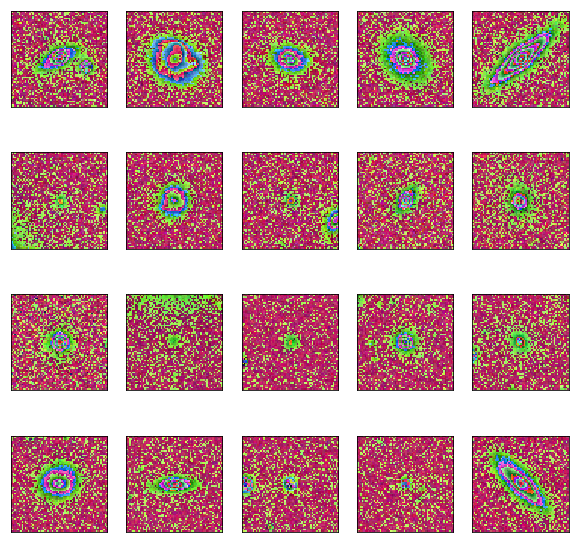

In [13]:
plt.figure(figsize=(10, 10))
for number in range(20):
    ax = plt.subplot(4,5,number+1)
    plt.imshow(train_data[number])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## 5.2 Hypercolumns clustering with the first 10 layers (Conv_1-5, Maxpool_1-5)
### 5.2.1 Kmeans on each 64*64 image

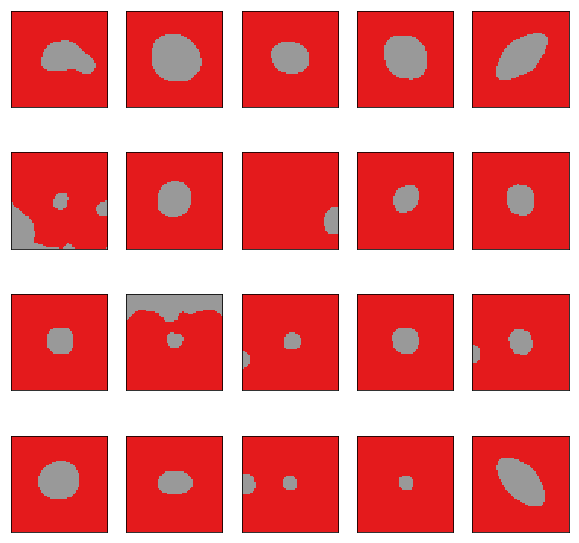

In [14]:
fig = plt.figure(figsize=(10, 10))
for number in range(20):
    No_ = number
    hypercolumns = []
    for i in range(np.shape(lyr)[0]-10):
        for l in range(lyr[i].output_shape[3]):
            hypercolumns.append(scipy.misc.imresize(lyr[i].predict(train_data[0:100],batch_size=100)[No_,:,:,l],size=(64,64),mode="F", interp='bilinear'))
    
    hypercolumns = np.asarray(hypercolumns)
    m=hypercolumns.transpose(1,2,0).reshape(64*64,-1)
    kmeans = cluster.KMeans(n_clusters=2, max_iter=300, n_jobs=1, precompute_distances=True)
    cluster_labels = kmeans.fit_predict(m)
    if np.mean(cluster_labels)>0.5:
        cluster_labels = -cluster_labels
    imcluster = np.zeros((64,64))
    imcluster = imcluster.reshape((64*64,))
    imcluster = cluster_labels
    ax = plt.subplot(4,5,number+1)
    plt.imshow(imcluster.reshape(64, 64), cmap="Set1")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

### 5.2.2 Use 25 images as inputs of kmeans

In [15]:
import scipy
#use the No_ th figure

RANGE=25
total_hyp = []
for No_ in range(RANGE):
    hypercolumns = []
    for i in range(np.shape(lyr)[0]-10):
        for l in range(lyr[i].output_shape[3]):
            hypercolumns.append(scipy.misc.imresize(lyr[i].predict(train_data[:100],batch_size=100)[No_,:,:,l],size=(64,64),mode="F", interp='bilinear'))
    total_hyp.append(hypercolumns)


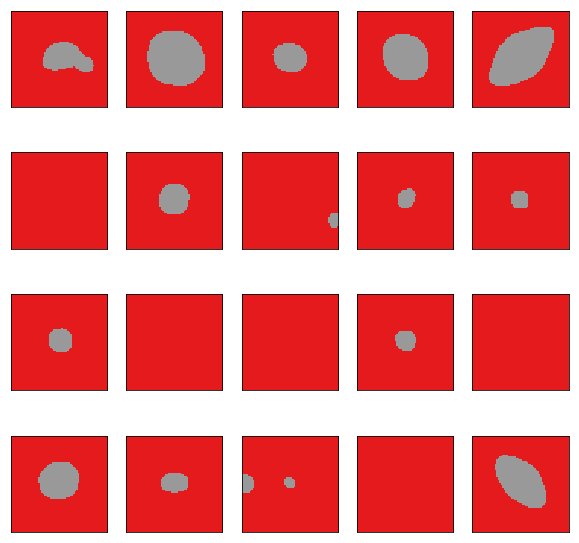

In [16]:
total_hyp = np.asarray(total_hyp)
m=total_hyp.transpose(0,2,3,1).reshape(64*64*RANGE,-1)
kmeans = cluster.KMeans(n_clusters=2, max_iter=300, n_jobs=1, precompute_distances=True)
cluster_labels = kmeans.fit_predict(m)

#imcluster = np.zeros((64,64,RANGE))
#imcluster = imcluster.reshape((64*64*RANGE,))
imcluster = cluster_labels
fig = plt.figure(figsize=(10, 10))
for i in range(RANGE-5):
    ax = plt.subplot(4,5,i+1)
    plt.imshow(imcluster[i*64*64:(i+1)*64*64].reshape(64, 64), cmap="Set1")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### 5.2.3 Another example

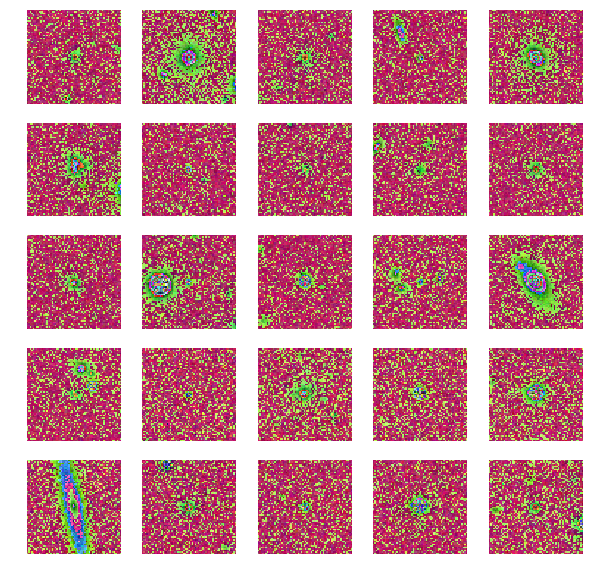

In [17]:
fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(10, 10))
for i in range(5):
    for j in range(5):
        idx = i * 5 + j
        ax[i, j].imshow(train_data[10000:10100][idx])
        ax[i, j].set_axis_off()

In [18]:
RANGE=25
total_hyp = []
for No_ in range(RANGE):
    hypercolumns = []
    for i in range(np.shape(lyr)[0]-10):
        for l in range(lyr[i].output_shape[3]):
            hypercolumns.append(scipy.misc.imresize(lyr[i].predict(train_data[10000:10100],batch_size=100)[No_,:,:,l],size=(64,64),mode="F", interp='bilinear'))
    total_hyp.append(hypercolumns)


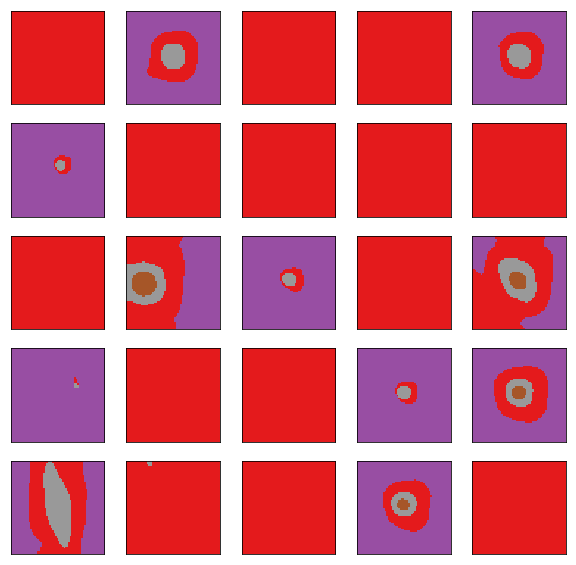

In [19]:
total_hyp = np.asarray(total_hyp)
m=total_hyp.transpose(0,2,3,1).reshape(64*64*RANGE,-1)
kmeans = cluster.KMeans(n_clusters=4, max_iter=300, n_jobs=1, precompute_distances=True)
cluster_labels = kmeans.fit_predict(m)

#imcluster = np.zeros((64,64,RANGE))
#imcluster = imcluster.reshape((64*64*RANGE,))
imcluster = cluster_labels
fig = plt.figure(figsize=(10, 10))
for i in range(RANGE):
    ax = plt.subplot(5,5,i+1)
    plt.imshow(imcluster[i*64*64:(i+1)*64*64].reshape(64, 64), cmap="Set1")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### 5.2.4 If only use the first 5 layers as inputs for Hypercolumns (Conv_1-3, Maxpool_1-2)

In [20]:
RANGE=25
total_hyp = []
for No_ in range(RANGE):
    hypercolumns = []
    for i in range(np.shape(lyr)[0]-15):
        for l in range(lyr[i].output_shape[3]):
            hypercolumns.append(scipy.misc.imresize(lyr[i].predict(train_data[10000:10100],batch_size=100)[No_,:,:,l],size=(64,64),mode="F", interp='bilinear'))
    total_hyp.append(hypercolumns)


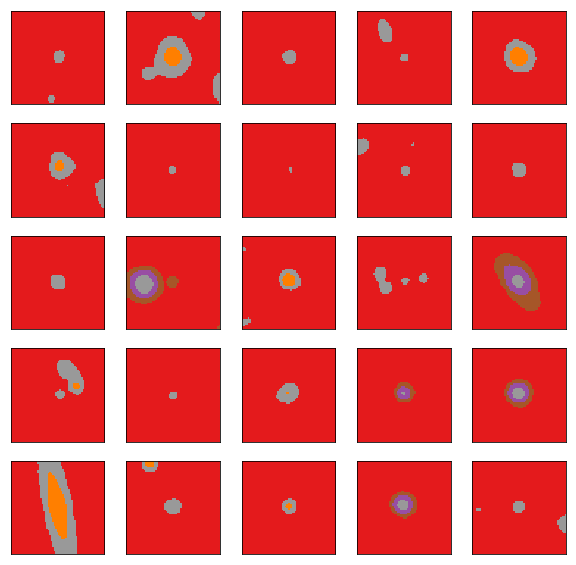

In [21]:
total_hyp = np.asarray(total_hyp)
m=total_hyp.transpose(0,2,3,1).reshape(64*64*RANGE,-1)
kmeans = cluster.KMeans(n_clusters=4, max_iter=300, n_jobs=1, precompute_distances=True)
cluster_labels = kmeans.fit_predict(m)

#imcluster = np.zeros((64,64,RANGE))
#imcluster = imcluster.reshape((64*64*RANGE,))
imcluster = cluster_labels
fig = plt.figure(figsize=(10, 10))
for i in range(RANGE):
    ax = plt.subplot(5,5,i+1)
    plt.imshow(imcluster[i*64*64:(i+1)*64*64].reshape(64, 64), cmap="Set1")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## 5.3 Use frame data
### 5.3.1 Load frame data

In [22]:
from astropy.io import fits
from scipy.ndimage import gaussian_gradient_magnitude
def scale(x):
    result = x - x.mean()
    result = (x - x.min()) / (x.max() - x.min())
    return result
def load_training_set(filenames, bands, num_classes, size):

    image_data = []
    for f in filenames:
        image_data.append(fits.getdata(f))
    image_data = np.stack(image_data)
        
    X_train, y_train = extract_patches(
        image_data,
        size=size,
        num_patches=num_classes
    )

    for idx, band in enumerate(bands):
        X = nanomaggie_to_luptitude(X_train[:, idx, :, :], band)
        X_train[:, idx, :, :] = scale(X)

    return X_train, y_train
def rms_of_gradient(array, size, sigma=1.0):
    """
    """

    result = np.zeros((array.shape[0], array.shape[1]))

    gradients = gaussian_gradient_magnitude(array, sigma=sigma)

    up = 0
    down = array.shape[0] - size
    left = 0
    right = array.shape[1] - size
    
    for i in range(up, down):
        for j in range(left, right):
            result[i, j] = rms(gradients[i: i + size, j: j + size])

    return result

def nanomaggie_to_luptitude(array, band):
    """
    Converts nanomaggies (flux) to luptitudes (magnitude).
    http://www.sdss.org/dr12/algorithms/magnitudes/#asinh
    http://arxiv.org/abs/astro-ph/9903081
    """
    b = {
        'u': 1.4e-10,
        'g': 0.9e-10,
        'r': 1.2e-10,
        'i': 1.8e-10,
        'z': 7.4e-10
    }
    nanomaggie = array * 1.0e-9 # fluxes are in nanomaggies

    luptitude = -2.5 / np.log(10) * (np.arcsinh((nanomaggie / (2 * b[band]))) + np.log(b[band]))
    
    return luptitude



def rms(x):

    return np.sqrt(np.mean(np.square(x)))

def extract_patches(array, size, num_patches, sigma=1.0, reference=None):
    """
    """

    nchannels, nrows, ncols = array.shape

    if reference is None:
        reference = nchannels // 2

    X = np.zeros((num_patches, nchannels, size, size))

    sog = rms_of_gradient(array[reference], size, sigma=sigma)

    sog = sog / np.sum(sog)

    # aligning images can produce NaN values in some pixels.
    # we will draw 10% more patches than specified and
    # skip images with any NaN values.
    nbuffer = int(0.1 * num_patches)

    pos = np.random.choice(
        np.arange(sog.size),
        size=num_patches + nbuffer,
        p=sog.reshape((sog.size, )),
        replace=False
    )

    row = pos // sog.shape[1]
    col = pos % sog.shape[1]

    for i in range(num_patches):
        icol = col[i]
        irow = row[i]
        patch = array[:, irow: irow + size, icol: icol + size]

        # as mentioned previously, some aligned images may have NaN values.
        # if there are any NaN values, continue.
        if np.sum(np.isnan(patch)) > 0:
            continue
        else:
            X[i] = patch

    X = X.astype(np.float32)
    y = np.arange(num_patches).astype(np.int32)

    return X, y

In [23]:
frames =[
    "frame-g-000109-2-0037.registered.fits",
    "frame-r-000109-2-0037.fits",
    "frame-i-000109-2-0037.registered.fits"
]

X, y = load_training_set(filenames=frames, bands="gri", num_classes=100, size=64)

print(X.shape)

(100, 3, 64, 64)


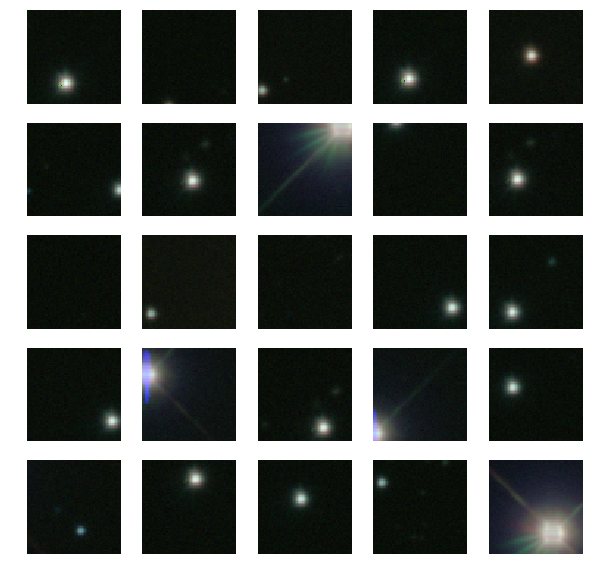

In [24]:
fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(10, 10))   
for i in range(5):
    for j in range(5):
        idx = i * 5 + j
        ax[i, j].imshow(1-X[idx].transpose(1, 2, 0))
        ax[i, j].set_axis_off()

In [25]:
X_frame = np.copy(X)
X_frame -= np.mean(X_frame)
X_frame /= np.max(X_frame)
Val_data = X_frame.transpose(0,2,3,1)

### 5.3.2 Kmeans on each 64*64 image

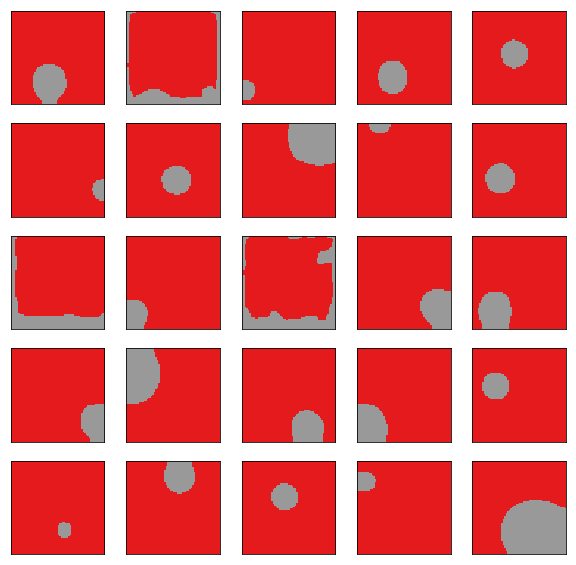

In [26]:
fig = plt.figure(figsize=(10, 10))
for number in range(25):
    No_ = number
    hypercolumns = []
    for i in range(np.shape(lyr)[0]-10):
        for l in range(lyr[i].output_shape[3]):
            hypercolumns.append(scipy.misc.imresize(lyr[i].predict(Val_data,batch_size=100)[No_,:,:,l],size=(64,64),mode="F", interp='bilinear'))
    
    hypercolumns = np.asarray(hypercolumns)
    m=hypercolumns.transpose(1,2,0).reshape(64*64,-1)
    kmeans = cluster.KMeans(n_clusters=2, max_iter=300, n_jobs=1, precompute_distances=True)
    cluster_labels = kmeans.fit_predict(m)
    if np.mean(cluster_labels)>0.5:
        cluster_labels = -cluster_labels
    imcluster = np.zeros((64,64))
    imcluster = imcluster.reshape((64*64,))
    imcluster = cluster_labels
    ax = plt.subplot(5,5,number+1)
    plt.imshow(imcluster.reshape(64, 64), cmap="Set1")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### 5.3.3 Kmeans on 25 images

In [27]:
RANGE=25
total_hyp = []
for No_ in range(RANGE):
    hypercolumns = []
    for i in range(np.shape(lyr)[0]-15):
        for l in range(lyr[i].output_shape[3]):
            hypercolumns.append(scipy.misc.imresize(lyr[i].predict(Val_data,batch_size=100)[No_,:,:,l],size=(64,64),mode="F", interp='bilinear'))
    total_hyp.append(hypercolumns)

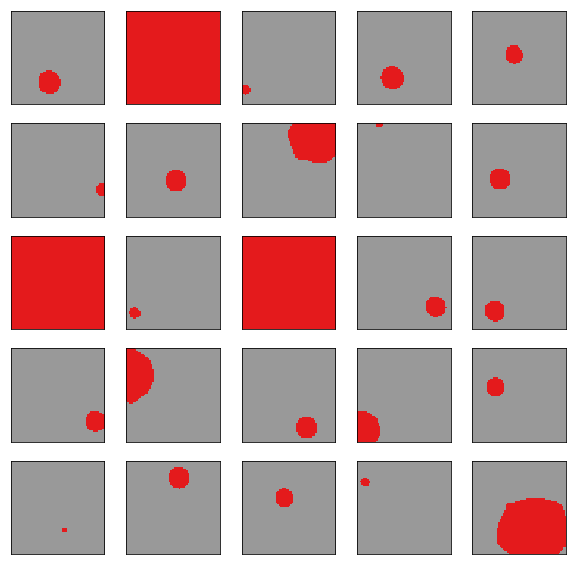

In [28]:
total_hyp = np.asarray(total_hyp)
m=total_hyp.transpose(0,2,3,1).reshape(64*64*RANGE,-1)
kmeans = cluster.KMeans(n_clusters=2, max_iter=300, n_jobs=1, precompute_distances=True)
cluster_labels = kmeans.fit_predict(m)

#imcluster = np.zeros((64,64,RANGE))
#imcluster = imcluster.reshape((64*64*RANGE,))
imcluster = cluster_labels
fig = plt.figure(figsize=(10, 10))
for i in range(RANGE):
    ax = plt.subplot(5,5,i+1)
    plt.imshow(imcluster[i*64*64:(i+1)*64*64].reshape(64, 64), cmap="Set1")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    #plt.gray()
plt.show()

# Part 6. Object Segmentation
We can also apply the same procedure to the SDSS field. For an image larger than $64\times64$, we can simply a $64\times64$ windows over the entire image and aggregate the results at the end.

In [29]:
field_images = [
    nanomaggie_to_luptitude(fits.getdata("frame-g-000109-2-0037.registered.fits"), 'g'),
    nanomaggie_to_luptitude(fits.getdata("frame-r-000109-2-0037.fits"), 'r'),
    nanomaggie_to_luptitude(fits.getdata("frame-i-000109-2-0037.registered.fits"), 'r')
]
field_images = np.stack(field_images)

field_images = field_images[:, 64: -64, 64: -64]
n_rows = 4
n_cols = 4

field_images = field_images[:, :64 * n_rows, :64 * n_cols]

assert np.sum(np.isnan(field_images)) == 0

for i in range(3):
    field_images[i] = scale(field_images[i])

In [30]:
segmented = np.zeros((n_rows * 64, n_cols * 64))
frame_data = []
for i in range(n_rows):
    for j in range(n_cols):
        tile = field_images[:, i * 64: (i + 1) * 64, j * 64: (j + 1) * 64]
        tile = tile.reshape((3, 64, 64)).transpose(1,2,0)
        frame_data.append(tile)
frame_data = np.asarray(frame_data)

In [31]:
frame_data -= np.mean(frame_data)
frame_data /= np.max(frame_data)

In [32]:
RANGE=16
total_hyp = []
for No_ in range(RANGE):
    hypercolumns = []
    for i in range(np.shape(lyr)[0]-15):
        for l in range(lyr[i].output_shape[3]):
            hypercolumns.append(scipy.misc.imresize(lyr[i].predict(frame_data,batch_size=16)[No_,:,:,l],size=(64,64),mode="F", interp='bilinear'))
    total_hyp.append(hypercolumns)

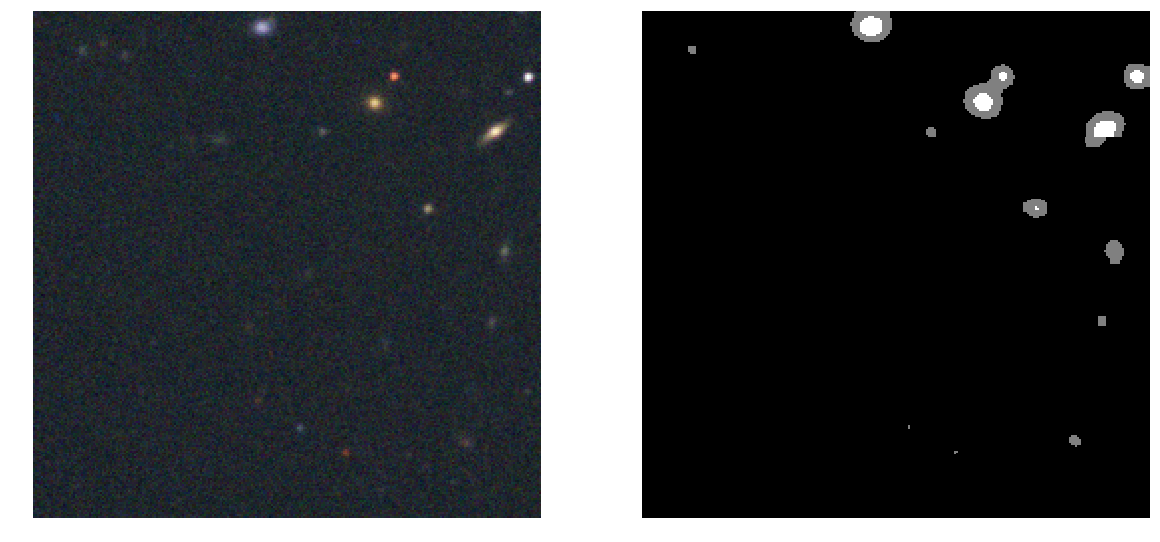

In [33]:
total_hyp = np.asarray(total_hyp)
m=total_hyp.transpose(0,2,3,1).reshape(64*64*RANGE,-1)
kmeans = cluster.KMeans(n_clusters=3, max_iter=300, n_jobs=1, precompute_distances=True)
cluster_labels = kmeans.fit_predict(m)
for i in range(n_rows):
    for j in range(n_cols):
        pred = kmeans.predict(m[(i*4+j)*64*64:(i*4+j+1)*64*64])
        pred = pred.reshape((64, 64))
        segmented[i * 64: (i + 1) * 64, j * 64: (j + 1) * 64] = pred
        
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 20))
plt.gray()
ax[0].imshow(1 - field_images[::-1].transpose((1, 2, 0)))
ax[0].axis("off")

ax[1].imshow(segmented)
ax[1].axis('off');